<a href="https://colab.research.google.com/github/dimlish/StarAlgorithm/blob/main/CosineStar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

%matplotlib inline

In [2]:
def generate_cosine_func(k, outer_max = 2):
    '''
    generates f(x) = a_1 cos (x) + a_2 cos (2x) + ... + a_k cos (kx)
    [a_1 ... a_k] = outer_coeffs
    a_i ~ U[-outer_max, outer_max]
    
    args:
        k - amount of cosine functions in sum
        outer_max - maximum absolute value of outer coefficient
    returns:
        f(x)
    '''

    outer_coeffs = (torch.rand(k) * 2 * outer_max - outer_max)
    inner_coeffs = torch.arange(1, k+1)
    def func(x_vec):
        res = []
        for x in x_vec:
            res.append(outer_coeffs @ torch.cos(inner_coeffs * x))
        return torch.tensor(res, dtype=torch.float32)

    return func;

class FuncDataset(torch.utils.data.Dataset):
    def __init__(self, size, sigma, f, x_len=3.14):
        self.x = (torch.rand(size) * x_len * 2)
        self.y = f(self.x) + torch.randn(size) * sigma

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def getall(self):
      return (self.x, self.y)

In [3]:
class ThinRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(1, 500)
        self.l2 = nn.Linear(500, 500)
        self.l3 = nn.Linear(500, 500)
        self.l4 = nn.Linear(500, 500)
        self.l5 = nn.Linear(500, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        return x

In [4]:
class StarRegression(nn.Module):
    def __init__(self, trained_model, ThinClass, *args):
        '''
        args:
            trained_model - trained model (its parameters are freezed)
            ThinClass - class of new model,
                        which will be connected with trained_model
                        and trained alongside weights of models (self.l)
            *args - arguments for ThinClass initialization 
        '''

        super().__init__()
        self.trained = trained_model
        for p in self.trained.parameters():
            p.requires_grad = False
        self.training = ThinClass(*args)
        self.l = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = self.l(torch.hstack((self.trained(x), self.training(x))))
        return x

In [5]:
class ThickRegression(nn.Module):
    def __init__(self, ThinClass, *args):
        '''
        args:
            ThinClass - class of models,
                        which will be connected with weights self.l
                        and trained in parallel alongside self.l
            *args - arguments for ThinClass initialization 
        '''
        super().__init__()
        self.m1 = ThinClass(*args)
        self.m2 = ThinClass(*args)
        self.l = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = self.l(torch.hstack((self.m1(x), self.m2(x))))
        return x

In [6]:
train_size = 750
test_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
b_size = 8
sigma = 0.05
k = 5
epoches = 100
enable_triple = False

f = generate_cosine_func(k)
train_set = FuncDataset(train_size, sigma, f)
test_set = FuncDataset(test_size, sigma, f)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=b_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=b_size)

thin = ThinRegression()
thick = ThickRegression(ThinRegression)
thin.to(device)
thick.to(device)
crit = nn.MSELoss()

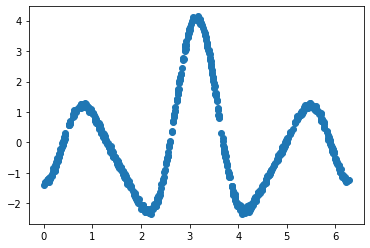

In [7]:
(x, y) = train_set.getall()
plt.scatter(x, y)
plt.show()

In [8]:
def train(model, trainloader, testloader, epoch_num, lr=0.01, tol=1e-5, test_freq=2, plot_graph=True, name=None):
    '''
    args:
    model - model to be trained
    trainloader - dataloader of training dataset
    testloader - dataloader of testing dataset
    epoch_num - amount of epoches to train
    lr - learning rate
    tol - tolerance of loss, if difference is < tol, training is stopped
    test_freq - every test_freq epoches loss on testing dataset is calculated
    plot_graph - if true, then graph is shown, else loss is printed
    name - name of model
    
    returns:
      losses - list of avg loss on training dataset per every test_freq epoches
    '''
    
    
    if name is not None:
        print("\n" + '-' * 50)
        print(name + ":")
    losses = []
    optimizer = optim.SGD(model.parameters(), lr)

    for epoch in range(epoch_num):
        for x_train, y_train in trainloader:
            x_train = x_train.reshape((x_train.shape[0], 1))
            y_train = y_train.reshape((y_train.shape[0], 1))
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
      
            loss = crit(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        if epoch % test_freq == 0:
            mean_val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_test, y_test in testloader:
                    x_test = x_test.reshape((x_test.shape[0], 1))
                    y_test = y_test.reshape((y_test.shape[0], 1))
                    x_test = x_test.to(device)
                    y_test = y_test.to(device)
                    y_pred = model(x_test)
                    loss = crit(y_pred, y_test)
                    mean_val_loss.append(loss.numpy())

            losses.append(np.mean(mean_val_loss))


            if plot_graph:
                clear_output(True)
                (x, y) = test_set.getall()
                x = x.reshape((test_size, 1))
                plt.scatter(x, y, c='black', label='true')
                y = model(x)
                plt.scatter(x, y.detach().numpy(), c='red', label=name)
                plt.legend(loc='upper left')
                plt.title("Epoch: {epoch}".format(epoch=epoch))
                plt.show()
            else:
                print('Epoch: {epoch}, loss: {loss}'.format(
                      epoch=epoch, loss=np.mean(mean_val_loss)))

            if losses[-1] != losses[-1]:
              raise ValueError("NaN loss")
            if len(losses) > 2 and abs(losses[-1] - losses[-2]) < tol:
                while len(losses) != epoch_num // test_freq:
                  losses.append(losses[-1]) # fill the list before finishing training
                break
    return losses

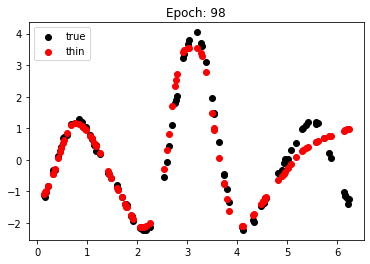

In [9]:
thin_losses = train(thin, train_loader, test_loader, epoches, name="thin")

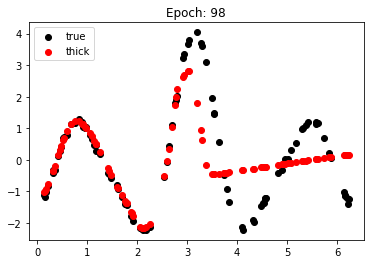

In [10]:
thick_losses = train(thick, train_loader, test_loader, epoches, name="thick")

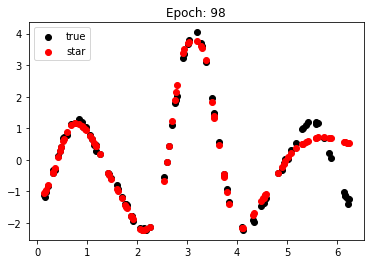

In [16]:
star = StarRegression(thin, ThinRegression)
star_losses = train(star, train_loader, test_loader, epoches, name="star")

In [12]:
if enable_triple:
    triple = StarRegression(star, ThinRegression) # star of star and thin
    triple_losses = train(triple, train_loader, test_loader, epoches, name="triple")

In [14]:
for p in star.l.named_parameters():
  print(p) # weights of neural networks in star
if enable_triple:
    for p in triple.l.named_parameters():
      print(p) # weights of neural networks in triple

('weight', Parameter containing:
tensor([[ 1.0099, -0.4982]], requires_grad=True))


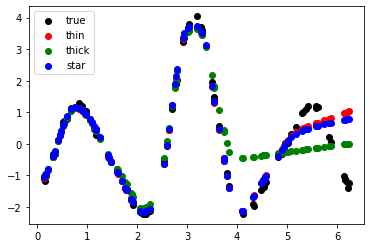

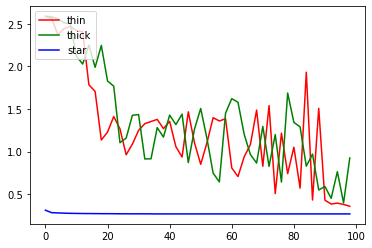

In [15]:
# Let's plot true values and predictions of our models for test dataset

plt.figure(1)

(x, y) = test_set.getall()
x = x.reshape((test_size, 1))
plt.scatter(x, y, c='black', label='true')

y = thin(x)
plt.scatter(x, y.detach().numpy(), c='r', label='thin')

y = thick(x)
plt.scatter(x, y.detach().numpy(), c='g', label='thick')

y = star(x)
plt.scatter(x, y.detach().numpy(), c='b', label='star')

if enable_triple:
    y = triple(x)
    plt.scatter(x, y.detach().numpy(), c='orange', label='triple')

plt.legend(loc='upper left')
plt.show()


# And let's plot losses of corresponding models

indexes = [i for i in range(0, epoches, 2)]

plt.figure(2)
plt.plot(indexes, thin_losses, c='r', label='thin')
plt.plot(indexes, thick_losses, c='g', label='thick')
plt.plot(indexes, star_losses, c='b', label='star')
if enable_triple:
    plt.plot(indexes, triple_losses, c='orange', label='triple')
plt.legend(loc='upper left')
plt.show()
